In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from mdn_model import MDNPerceptron
from convolutional_mdn_model import ConvMDNPerceptron
import torch.nn as nn
import pickle

In [2]:
n_samples = 1000

#epsilon = torch.randn(n_samples)
epsilon = torch.randn(n_samples, 2)
#x_data = torch.linspace(-10, 10, n_samples)
a = np.linspace(-10, 10, n_samples)
x_data = torch.from_numpy(np.vstack([a,a]).T)
y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon

# swap x and y
#y_data, x_data = x_data.view(-1,1), y_data.view(-1,1)
y_data, x_data = x_data.view(-1,2), y_data.view(-1,2)

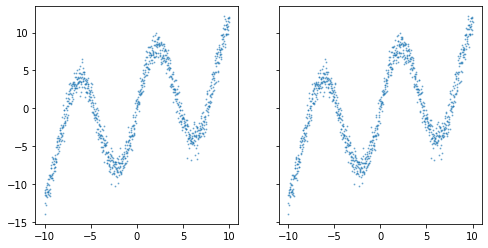

In [3]:
plt.ion()
#fig = plt.figure(figsize=(4,10))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))
line1 = ax1.scatter(y_data.numpy(), x_data.numpy(), alpha=0.5, s=0.8)
line1 = ax2.scatter(y_data.numpy(), x_data.numpy(), alpha=0.5, s=0.8)
line2 = None
line3 = None
fig.canvas.draw()
#fig.savefig('images/initial.png', bbox_inches='tight')

In [3]:
x_data = x_data.float()
y_data = y_data.float()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_data = x_data.to(device)
y_data = y_data.to(device)

# regular NN

In [58]:
hidden_size = 20
model = nn.Sequential(nn.Linear(2, hidden_size), #nn.Linear(1, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, 2), #nn.Linear(hidden_size, 1),
                      ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mseloss = nn.MSELoss()

In [60]:
for epoch in range(130):
    optimizer.zero_grad()
    y = model(x_data)
    loss = mseloss(x_data, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Loss: ' + str(loss.item()))
        y_pred = model(x_data)

        x_plot = x_data.data.squeeze().cpu().numpy()
        y_plot = y_pred.data.squeeze().cpu().numpy()

        if line2 is None:
            line2 = ax1.scatter(y_plot, x_plot, alpha=0.6, s=0.9)
        else:
            line2.set_offsets(np.c_[y_plot, x_plot])
        #fig.canvas.draw_idle()
        #fig.savefig('images/linear%04d.png' % (epoch,), bbox_inches='tight')
        plt.pause(0.1)

Loss: 28.488645553588867
Loss: 26.371379852294922
Loss: 23.312833786010742
Loss: 19.083433151245117
Loss: 13.663039207458496
Loss: 7.737053871154785
Loss: 2.8545098304748535
Loss: 0.8898286819458008
Loss: 0.7123157382011414
Loss: 0.5378992557525635
Loss: 0.5050364136695862
Loss: 0.46583300828933716
Loss: 0.43323540687561035


# MDN

In [22]:
model = MDNPerceptron(2, 10, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
for epoch in range(10000):
    optimizer.zero_grad()
    pi, mu, sigma = model(x_data)
    loss = model.loss_fn(y_data, pi, mu, sigma)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print('Loss: ' + str(loss.item()))

        pi, mu, sigma = model(x_data)
        y_pred = model.sample(pi, mu, sigma)

        x_plot = x_data.data.squeeze().cpu().numpy()
        y_plot = y_pred.data.squeeze().cpu().numpy()

        #if line3 is None:
        #    line3 = ax2.scatter(y_plot, x_plot, alpha=0.6, s=0.9)
        #else:
        #    line3.set_offsets(np.c_[y_plot, x_plot])
        #fig.canvas.draw_idle()
        #fig.savefig('images/mdn%04d' % (epoch, ) + '.png', bbox_inches='tight')
        plt.pause(0.1)

Loss: 27.842769622802734
Loss: 5.395568370819092
Loss: 4.392596244812012
Loss: 3.790703535079956
Loss: 3.1517333984375
Loss: 2.2906973361968994
Loss: 1.8459542989730835
Loss: 1.6670664548873901
Loss: 1.5320254564285278
Loss: 1.4837989807128906


In [24]:
test_pts = [[0,0], [1,5]]
pi_test, mu_test, sigma_test = model.forward(torch.Tensor(test_pts))

In [25]:
pi_test

tensor([[0.0938, 0.0523, 0.6125, 0.2414],
        [0.1693, 0.1580, 0.4672, 0.2056]], grad_fn=<SoftmaxBackward>)

In [26]:
mu_test

tensor([[-0.1697, -0.1639,  5.5323,  5.5163, -7.0414, -7.0361,  5.9869,  5.8615],
        [ 0.5197,  0.5194,  8.1103,  8.1127, -6.1426, -6.1437,  4.0627,  4.0618]],
       grad_fn=<AddmmBackward>)

In [27]:
sigma_test

tensor([[0.0267, 0.0217, 0.0118, 0.0065, 1.0156, 1.0122, 0.9546, 1.1064],
        [0.0198, 0.0193, 0.0152, 0.0153, 0.4619, 0.4620, 0.0213, 0.0210]],
       grad_fn=<ExpBackward>)

# convolutional MDN

In [3]:
with open('binary_edge_data_20210202.pkl', 'rb') as handle:
    x_train, x_test, y_train, y_test = pickle.load(handle)

In [4]:
x_data = torch.from_numpy(np.array(x_train).reshape(6000,1,20,20)).float()

y_data = torch.Tensor(y_train).float()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_data = x_data.to(device)
y_data = y_data.to(device)

In [7]:
def plot_binary_edge_image(image):
    cmap = colors.ListedColormap(['white','black'])
    plt.figure(figsize=(6,6))
    plt.pcolor(image[::-1], cmap=cmap, edgecolors='w', linewidths=0)
    plt.show()
    return

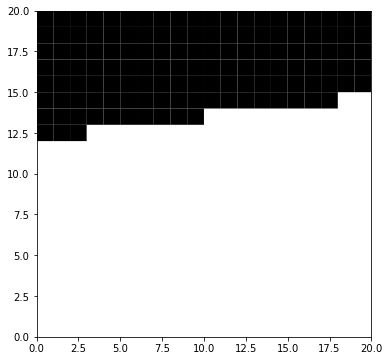

In [8]:
plot_binary_edge_image(x_train[0])

In [22]:
model = ConvMDNPerceptron(10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
for epoch in range(5000):
    optimizer.zero_grad()
    pi, mu, sigma = model(x_data)
    loss = model.loss_fn(y_data, pi, mu, sigma)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print('Loss: ' + str(loss.item()))

Loss: 26.056489944458008
Loss: 3.4059622287750244
Loss: 3.2667064666748047
Loss: 3.4791510105133057
Loss: 3.040785789489746
Loss: 2.9416959285736084
Loss: 3.0961623191833496
Loss: 2.786193609237671
Loss: 2.7183189392089844
Loss: 2.658259630203247


In [24]:
test_pts = [x_test[0], x_test[1]]
pi_test, mu_test, sigma_test = model.forward(torch.Tensor(test_pts).reshape(2,1,20,20))

In [25]:
pi_test

tensor([[1.],
        [1.]], grad_fn=<SoftmaxBackward>)

In [26]:
mu_test

tensor([[ 4.2632, -5.6861],
        [ 1.7734,  2.3545]], grad_fn=<AddmmBackward>)

In [27]:
sigma_test

tensor([[0.1465, 1.1572],
        [0.0483, 4.0698]], grad_fn=<ExpBackward>)

In [28]:
y_test[0]

[4.325607600954093, -6.467741456662033]

In [29]:
y_test[1]

[1.5046277555560528, 1.6697732302090262]

In [32]:
pi_test, mu_test, sigma_test = model.forward(
    torch.from_numpy(np.array(x_test).reshape(4000,1,20,20)).float()
    )

In [35]:
pi_test

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward>)

In [36]:
mu_test

tensor([[ 4.2632, -5.6861],
        [ 1.7734,  2.3545],
        [ 4.3710,  7.2444],
        ...,
        [ 3.3856, -7.6983],
        [ 0.9474, -4.9980],
        [ 4.5655, -8.1382]], grad_fn=<AddmmBackward>)

In [37]:
sigma_test

tensor([[0.1465, 1.1572],
        [0.0483, 4.0698],
        [0.2875, 0.4842],
        ...,
        [0.4867, 0.4906],
        [7.2393, 4.0530],
        [2.5167, 0.6324]], grad_fn=<ExpBackward>)